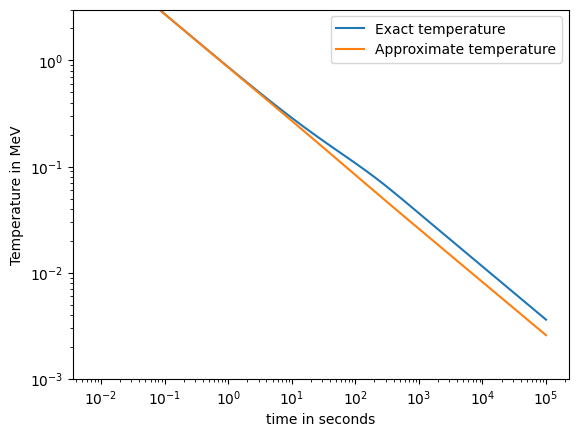

In [94]:
#Background

import scipy.constants as con
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt


#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
n_life=613.9*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K

T_ini=10 #initial temperature in MeV
e_mass=0.51099895 #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=h_ini*T_ini**3     #initial baryon density, currently set to 0

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(T,h,a):
    return h_ini*T_ini**3/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,h,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(T,h,a)

def rho_set(T,h,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,h,a)

def H(T,h,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,h,a))



#Derivative from Kavano D.18
def dTdt(t,T,h,a):
    return -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h,a) + P_e(T)+P_gamma(T)))




dTdt(1,T_ini,h_ini,1)*timeunit

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,h,a):
    return a*H(T,h,a)


t_range=[t_ini,1e5*timeunit]            #time range for integration
t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,h_ini,1],method='Radau')#,t_eval=t_space)


# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Exact temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[2], label='Approximate temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()






In [95]:
#test background temperature
sol.y[0][-1]/(T_ini/sol.y[2][-1])
sol.y[0]/(T_ini/sol.y[2])
#nsten=20
#print(sol.y[0][nsten])
#print(sol.y[0][nsten]/(T_ini/sol.y[2][nsten]))

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.00000001, 1.00000012, 1.00000123,
       1.00001231, 1.00002686, 1.00005944, 1.00010368, 1.00013698,
       1.00022272, 1.00034029, 1.00047719, 1.00070659, 1.00100877,
       1.0014068 , 1.00199616, 1.00275921, 1.00380642, 1.00528546,
       1.00717881, 1.00980148, 1.01340837, 1.01795428, 1.02418252,
       1.03250005, 1.04268096, 1.05618213, 1.07340957, 1.09346853,
       1.1185989 , 1.14857526, 1.18096401, 1.21812691, 1.25795146,
       1.29558102, 1.33160309, 1.36149158, 1.3813059 , 1.39297814,
       1.39804154, 1.39959919, 1.39994937, 1.40000669, 1.40000832,
       1.39994839, 1.39993086, 1.39992322, 1.39986025, 1.39984143,
       1.39983302, 1.39976621, 1.3997453 , 1.39973563, 1.39966244,
       1.39963797, 1.39962618, 1.39962367])

In [96]:
#Reaction rates
nNucs=12
Y_ini=np.zeros(nNucs)


Xn_ini = 1/(np.exp(Q/T_ini)+1)

Y_ini[0] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[1] = Xn_ini        #Set initial neutron mass fraction




def lambda_n2p(T):  #analytic approximation of the neutron to proton reaction rate, 
                    #as a function of photon temperature
    z=e_mass/T
    return 1/n_life*(1 + 0.565/z - 6.382/z**2 + 11.108/z**3 + 36.492/z**4 + 27.512/z**5)
    
def lambda_p2n(T):  #analytic approximation of the proton to neutron reaction rate, 
                    #as a function of photon temperature
    z=e_mass/T
    return 1/n_life*(5.252/z - 16.229/z**2 + 18.059/z**3 + 34.181/z**4 + 27.617/z**5)*np.exp(-Q/T)



#making the rates an array of functions
rates=np.array([[lambda i: 0 for i in range(nNucs)] for j in range(nNucs)])

rates[0][1]=lambda_p2n
rates[1][0]=lambda_n2p

#making the rates a temperature dependant array
def frates(T):
    
    rate=np.zeros([nNucs,nNucs])
    rate[0][1]=lambda_p2n(T)
    rate[1][0]=lambda_n2p(T)

    return rate



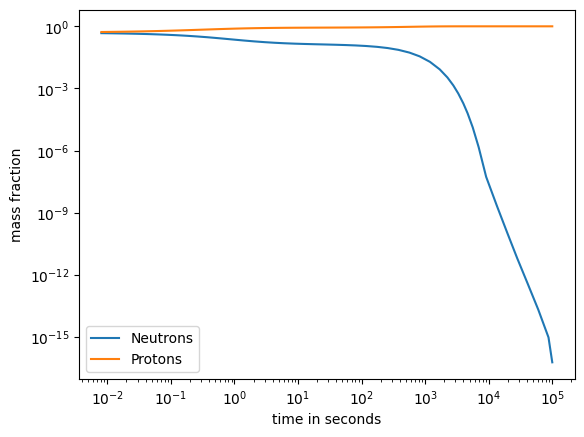

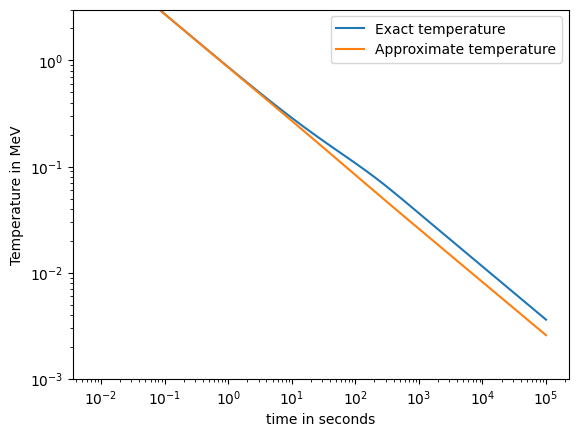

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.00000001, 1.00000012, 1.00000123,
       1.00001231, 1.00002686, 1.00005944, 1.00010368, 1.00013698,
       1.00022272, 1.00034029, 1.00047719, 1.00070659, 1.00100877,
       1.0014068 , 1.00199616, 1.00275921, 1.00380642, 1.00528546,
       1.00717881, 1.00980148, 1.01340837, 1.01795428, 1.02418252,
       1.03250005, 1.04268096, 1.05618213, 1.07340957, 1.09346853,
       1.1185989 , 1.14857526, 1.18096401, 1.21812691, 1.25795146,
       1.29558102, 1.33160309, 1.36149158, 1.3813059 , 1.39297814,
       1.39804154, 1.39959919, 1.39994937, 1.40000669, 1.40000832,
       1.39994839, 1.39993086, 1.39992322, 1.39986025, 1.39984143,
       1.39983302, 1.39976621, 1.3997453 , 1.39973563, 1.39966244,
       1.39963797, 1.39962618, 1.39962367])

In [99]:
#Solving abundances

n_bparams=3

def dYdt(t,Y,T):
    DYdt=np.zeros(nNucs)
    DYdt[0] = Y[1]*lambda_n2p(T) - Y[0]*lambda_p2n(T)
    DYdt[1] = Y[0]*lambda_p2n(T) - Y[1]*lambda_n2p(T)
    return DYdt


def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]


def dall(t,y):   #solve h and T, y[0] = T and y[1] = h
    return [dTdt(t,*y[:n_bparams]),dhdt(t,*y[:n_bparams]),dadt(t,*y[:n_bparams])]+list(dYdt(t,y[n_bparams:],y[0]))

solY = integrate.solve_ivp(dall, t_range, [T_ini,h_ini,1]+list(Y_ini),method='Radau')#,t_eval=t_space)

# Plot the background solution
plt.figure('abundance')
plt.plot(solY.t/timeunit, solY.y[n_bparams+1], label='Neutrons')
plt.plot(solY.t/timeunit, solY.y[n_bparams], label='Protons')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')
plt.xlabel('time in seconds')
plt.ylabel('mass fraction')

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Exact temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[2], label='Approximate temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()


(10, 0.001)

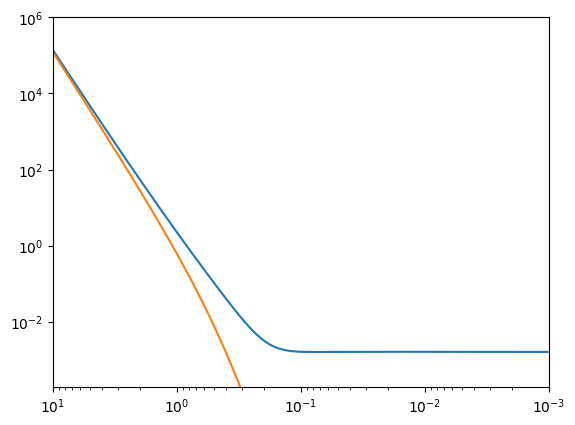

In [62]:
#plotting Neutron-proton conversion rates
import matplotlib.pyplot as plt

T=np.logspace(1,-3,1000)

fig=plt.figure()


plt.xscale('log')
plt.yscale('log')

plt.plot(T,timeunit*lambda_n2p(T))
plt.plot(T,timeunit*lambda_p2n(T))

plt.ylim((2e-4, 1e6))
plt.xlim((10, 1e-3))

In [63]:
#temperature conversion tests
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K

T_ini=1 #initial temperature in MeV

t_ini=(10.4)**2/((T_ini*TMeV2T9))**2
print(t_ini)

0.8031792066848201


-3.7750917756204343


/tmp/ipykernel_11362/575522332.py:29: RuntimeWarning: invalid value encountered in divide
  plt.plot(z,dB(z)/dB2)


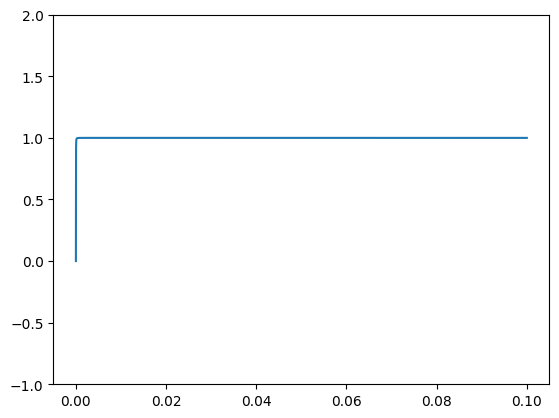

In [64]:
#test of numerical to analytical gradients


import numpy as np
from scipy import special
import matplotlib.pyplot as plt

def B(z):
    return 1/4*special.kn(1,z)/z
    return 3/4*special.kn(3,z)/z#+1/4*special.kn(1,z)/z

def dB(z):
    return -special.kn(2,z)/z/4
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z*3/4




z=np.linspace(0,0.1,10000)

dB2 = np.gradient(B(z), z)

fig2=plt.figure()

plt.ylim([-1,2])
print(dB(0.5))
#print(dB2(0.5))

plt.plot(z,dB(z)/dB2)
#plt.plot(z,dB2,'--')

0.5525810773928187


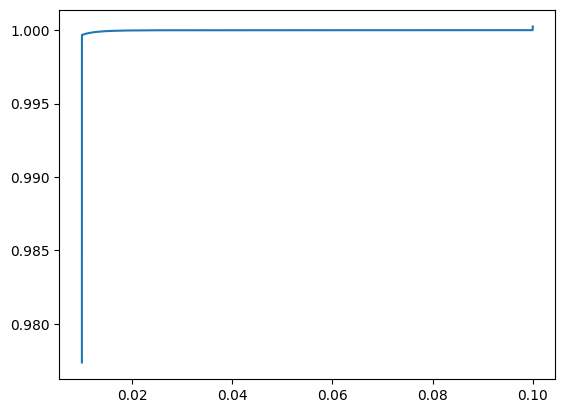

In [65]:
#test of numerical to analytical gradients

e_mass=0.51099895
def rho_e(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)],axis=0)

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)],axis=0)



T=np.linspace(0.1,1e-2,10000)

dB2 = np.gradient(rho_e(T), T)

fig2=plt.figure()
#plt.xlim([0,2])
#plt.ylim([0,20])
print(drho_e(0.5))
#print(dB2(0.5))

#plt.plot(T,drho_e(T))
#plt.plot(T,dB2,'--')

#plt.yscale('log')
plt.plot(T,drho_e(T)/dB2)



/tmp/ipykernel_11362/3084481361.py:17: RuntimeWarning: overflow encountered in exp
  func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))


0.06618000092017698


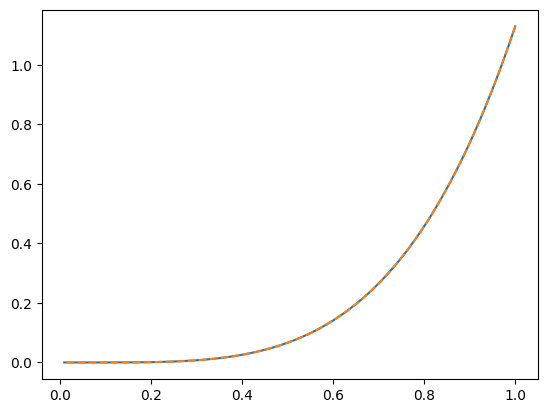

In [66]:
#test of numerical to analytical energy density

import numpy as np
from scipy import special
import matplotlib.pyplot as plt


'''
'''
e_mass=0.51099895
def rho_e(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)],axis=0)

def rho_e2(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))
 
    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)],axis=0)



T=np.linspace(1,1e-2,1000)

dB2 = np.gradient(rho_e(T), T)

fig2=plt.figure()
#plt.xlim([0,2])
#plt.ylim([0,20])

print(rho_e2(0.5))
#print(dB2(0.5))

plt.plot(T,rho_e(T))
plt.plot(T,[rho_e2(T1) for T1 in T],'--')




In [67]:
'''
#dum fix til at have dTdt værende afhængig af sig selv
def dTdt(t,T,h,a):
    bounds= -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T) ))

    #Varmfix  - drho_e(T)*x/3*H(T,h,a)
    eqn = lambda x: -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T)))-x
    tempsol = root_scalar(eqn, method='brentq',bracket=[bounds/2,bounds*2])
    return np.array([tempsol.root,bounds])

dTdt(1,T_ini,h_ini,1)*timeunit
'''

"\n#dum fix til at have dTdt værende afhængig af sig selv\ndef dTdt(t,T,h,a):\n    bounds= -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T) ))\n\n    #Varmfix  - drho_e(T)*x/3*H(T,h,a)\n    eqn = lambda x: -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T)))-x\n    tempsol = root_scalar(eqn, method='brentq',bracket=[bounds/2,bounds*2])\n    return np.array([tempsol.root,bounds])\n\ndTdt(1,T_ini,h_ini,1)*timeunit\n"

In [105]:
#test neutron/proton ratio
timepoint=45
print(solY.t[timepoint]/timeunit)
#
solY.y[4][timepoint]/solY.y[3][timepoint]




38.41962041177248


0.14814520771930023